## 1. NPL with Disaster tweets
#### The goal of the project is predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.
 - Given ~10,000 tweet samples
 - Evaluation metric used to evaluate performance is the F1 score.

#### This is a Natural Language Processing (NLP) problem because the main input is text (tweets).
**The raw data is:**

- A text of a tweet.
- A target column (0/1 disaster label) in the training set.
- An id(a unique identifier for each tweet) column  in both train and test.

**The structure of the data includes 10,000 samples (tweets). Each sample has a short text (tweet) + labels (for training).**

In [1]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.20.0
KerasNLP version: 0.19.0


In [3]:
df_train = pd.read_csv("/Users/oakmoreroadinc./Downloads/nlp-getting-started/train.csv")
df_test = pd.read_csv("/Users/oakmoreroadinc./Downloads/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


## 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 

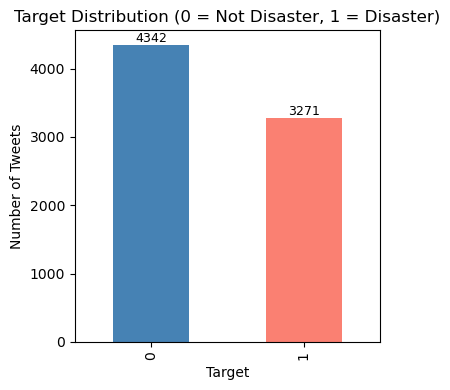

There are 0 duplicate rows.
There are 2594 missing values in total.


In [4]:
# EDA: label counts
#This shows how many tweets are real disasters (1) and how many are not (0).
target_counts=df_train['target'].value_counts().sort_index()

plt.figure(figsize=(4, 4))
target_counts.plot(kind='bar', color=['steelblue', 'salmon'])

plt.title('Target Distribution (0 = Not Disaster, 1 = Disaster)')
plt.xlabel('Target')
plt.ylabel('Number of Tweets')

# Add value labels on top of bars
for i, v in enumerate(target_counts):
    plt.text(i, v + 50, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

#Cleaning procedures(preprocessing)
duplicate_rows = df_train.duplicated().sum()
print(f"There are {duplicate_rows} duplicate rows.")
#Finding Missing Values for all columns.
total_missing_values = df_train.isnull().sum().sum()
print(f"There are {total_missing_values} missing values in total.")

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
#preprocessing 
#fill missing values
df_train['keyword'] = df_train['keyword'].fillna('unknown')
df_train['location'] = df_train['location'].fillna('unknown')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7613 non-null   object
 2   location  7613 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
df_train.head()

,id,keyword,location,text,target
0,1,unknown,unknown,Our Deeds are the Reason of this #earthquake M...,1
1,4,unknown,unknown,Forest fire near La Ronge Sask. Canada,1
2,5,unknown,unknown,All residents asked to 'shelter in place' are ...,1
3,6,unknown,unknown,"13,000 people receive #wildfires evacuation or...",1
4,7,unknown,unknown,Just got sent this photo from Ruby #Alaska as ...,1


### EDA Analysis:
In this step, I first plotted a simple bar chart of the target column to see how many tweets are labeled as real disasters (1) versus not disasters (0). This helps me quickly understand whether the dataset is balanced or if one class appears much more often than the other. I then checked for duplicate rows and the total number of missing values to make sure there were no major data quality issues. Since the keyword and location columns contained missing values, I filled them with the placeholder "unknown" so that the model can still use these fields without dropping any rows. Going forward, my plan is to mainly use the tweet text for modeling, while optionally exploring whether including keyword and location (with "unknown" filled in) improves the prediction performance.

## 3. Model Architecture 

In [8]:
# Features and labels
X = df_train['text']          # tweets
y = df_train['target']        # 0 or 1

# Train/validation split (80% / 20%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create TF-IDF vectorizer(preprocessing)
tfidf = TfidfVectorizer(
    max_features=10000,      # limit vocab size
    ngram_range=(1, 2),      # unigrams + bigrams (optional)
    stop_words='english'     # optional: remove English stopwords
)

# Fit on training text and transform both train and val
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)

X_train_tfidf.shape, X_val_tfidf.shape

log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

log_reg.fit(X_train_tfidf, y_train)

# Predict probabilities and then class labels
y_val_pred_proba = log_reg.predict_proba(X_val_tfidf)[:, 1]
y_val_pred = (y_val_pred_proba >= 0.5).astype(int)

# Evaluate with F1 score
f1 = f1_score(y_val, y_val_pred)
print(f"Validation F1 (TF-IDF + Logistic Regression): {f1:.4f}")


Validation F1 (TF-IDF + Logistic Regression): 0.7648


In this step, I built a simple **baseline model** to see how well we can predict disaster tweets using only the tweet text. First, I split the data into a training set (80%) and a validation set (20%) so I could train the model on one part and fairly test it on another. I then used **TF-IDF** to turn the raw text into numerical features that capture how important each word (and word pair) is in each tweet. On top of these features, I trained a **Logistic Regression classifier** to predict whether each tweet is about a real disaster (1) or not (0). The model achieved an **F1 score of 0.7648** on the validation set, which means it has a reasonably good balance between correctly finding disaster tweets (recall) and not mislabeling too many non-disaster tweets as disasters (precision), and this score will serve as the baseline to compare more advanced neural network models against.

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models


# Features and labels
X = df_train['text'].astype(str)
y = df_train['target'].values

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Tokenize text(preprocessing)
max_words = 20000      # Maximum number of words to keep in the vocabulary (most frequent words)
max_len = 40           # Maximum length of each tweet in tokens (words) after padding/truncating


#preprocessing
# Create a Tokenizer that will convert words to integer IDs.
# num_words limits vocab size; oov_token is used for words not seen during training ("out of vocab").
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
# Learn the word index (mapping word -> number) from the training texts only
tokenizer.fit_on_texts(X_train)

# Convert the training tweets from text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
# Convert the validation tweets from text to sequences of integers
X_val_seq   = tokenizer.texts_to_sequences(X_val)

# Convert the validation tweets from text to sequences of integers
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')

# Do the same padding/truncating for the validation sequences
X_val_pad   = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

# Check the shape (number of samples, length of each sequence)
X_train_pad.shape, X_val_pad.shape

# ----- GRU MODEL DEFINITION -----

def build_gru_model(
    max_words=20000,   # size of the vocabulary (same as above)
    max_len=40,        # length of input sequences (same as above)
    embedding_dim=64,  # size of each word's embedding vector
    gru_units=64,      # number of GRU units (hidden size)
    dropout_rate=0.2,  # dropout rate for regularization
    lr=1e-3            # learning rate for the optimizer
):
    # Define the input layer: each sample is a sequence of integers of length max_len
    inputs = layers.Input(shape=(max_len,))

    # Embedding layer: turns each integer (word ID) into a dense vector of size embedding_dim
    x = layers.Embedding(max_words, embedding_dim)(inputs)

    # GRU layer: processes the sequence and learns patterns over time (word order).
    # return_sequences=True means it outputs a sequence (one vector per time step).
    x = layers.GRU(gru_units, return_sequences=True)(x)

    # GlobalMaxPooling1D: takes the maximum value over time for each feature,
    # compressing the sequence into a single vector.
    x = layers.GlobalMaxPooling1D()(x)

    # Dropout: randomly turns off some neurons during training to reduce overfitting
    x = layers.Dropout(dropout_rate)(x)

    # Dense (fully connected) layer with ReLU activation: learns higher-level features
    x = layers.Dense(32, activation='relu')(x)

    # Output layer: 1 neuron with sigmoid activation for binary classification (0 or 1)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Build the model that connects inputs to outputs
    model = models.Model(inputs, outputs)

    # Adam optimizer with a given learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Compile the model: define loss function and metrics
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',  # good for binary classification
        metrics=['accuracy']         # track accuracy during training
    )

    # Return the compiled model so we can train it
    return model

In [11]:
# List of different hyperparameter combinations  to try for the GRU model
gru_param_grid = [
    # 1st configuration: smaller embedding & GRU, low dropout, standard learning rate, larger batch size
    {'embedding_dim': 64,  'gru_units': 64,  'dropout_rate': 0.2, 'lr': 1e-3,  'batch_size': 64},
    # 2nd configuration: same embedding, more GRU units, a bit more dropout
    {'embedding_dim': 64,  'gru_units': 128, 'dropout_rate': 0.3, 'lr': 1e-3,  'batch_size': 64},
    # 3rd configuration: larger embedding, many GRU units, heavy dropout, smaller learning rate, smaller batch size
    {'embedding_dim': 128, 'gru_units': 128, 'dropout_rate': 0.5, 'lr': 5e-4, 'batch_size': 32},
]

# Empty list to store results for each hyperparameter configuration
gru_results = []

#best_gru_model = None       # will hold the best trained GRU model
#best_gru_params = None      # will hold the best hyperparameters
#best_gru_f1 = 0.0           # will hold the best F1 score


# Loop over each hyperparameter set in the grid
for params in gru_param_grid:
    # Print which hyperparameters we’re using in this run
    print("\nTraining GRU with params:", params)
    
    # Build a new GRU model using the current set of hyperparameters
    model = build_gru_model(
        max_words=max_words,
        max_len=max_len,
        embedding_dim=params['embedding_dim'],
        gru_units=params['gru_units'],
        dropout_rate=params['dropout_rate'],
        lr=params['lr']
    )

    # Define callbacks for training; here we use EarlyStopping
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',        # watch the validation loss
            patience=2,                # stop if it doesn't improve for 2 epochs
            restore_best_weights=True  # revert to the best weights seen during training
        )
    ]

    # Train the model on the padded training data
    history = model.fit(
        X_train_pad, y_train,             # training inputs and labels
        validation_data=(X_val_pad, y_val),  # validation set for monitoring performance
        epochs=8,                         # maximum number of epochs
        batch_size=params['batch_size'],  # batch size from current hyperparameters
        callbacks=callbacks,              # use EarlyStopping
        verbose=1                         # show training progress
    )

    # ----- Evaluate model using F1 score -----

    # Get predicted probabilities on the validation set (values between 0 and 1)
    y_val_pred_proba = model.predict(X_val_pad).ravel()
    
    # Convert probabilities to class labels: 1 if >= 0.5, else 0
    y_val_pred = (y_val_pred_proba >= 0.5).astype(int)
    
    # Calculate F1 score for this configuration
    f1 = f1_score(y_val, y_val_pred)

    # Print the F1 score for this run
    print(f"GRU F1: {f1:.4f}")
    
    # Save the hyperparameters and the corresponding F1 to compare later
    gru_results.append({'params': params, 'f1': f1})



Training GRU with params: {'embedding_dim': 64, 'gru_units': 64, 'dropout_rate': 0.2, 'lr': 0.001, 'batch_size': 64}
Epoch 1/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6677 - loss: 0.6045 - val_accuracy: 0.7905 - val_loss: 0.4655
Epoch 2/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8570 - loss: 0.3531 - val_accuracy: 0.7905 - val_loss: 0.4654
Epoch 3/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9273 - loss: 0.1884 - val_accuracy: 0.8070 - val_loss: 0.5458
Epoch 4/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9604 - loss: 0.1087 - val_accuracy: 0.7899 - val_loss: 0.5643
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
GRU F1: 0.7656

Training GRU with params: {'embedding_dim': 64, 'gru_units': 128, 'dropout_rate': 0.3, 'lr': 0.001, 'batch_size': 64}
Epoch 1/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6537 - loss: 0.6238 - val_accuracy: 0.7932 - val_loss: 0.4626
Epoch 2/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8521 - loss: 0.

In [12]:
def build_lstm_model(
    max_words=20000,   # maximum vocabulary size (how many distinct words we keep)
    max_len=40,        # maximum length of each input sequence (number of tokens)
    embedding_dim=64,  # size of the word embedding vector
    lstm_units=64,     # number of units (hidden size) in the LSTM layer
    dropout_rate=0.3,  # dropout rate for regularization
    lr=1e-3            # learning rate for the optimizer
):
    # Define a Sequential model: layers are stacked one after another
    model = models.Sequential([
        # Embedding layer: turns word indices (integers) into dense vectors of size embedding_dim
        layers.Embedding(input_dim=max_words, output_dim=embedding_dim),

        # Bidirectional LSTM: reads the sequence forward and backward to capture more context.
        # return_sequences=False means it outputs a single vector (final state), not the full sequence.
        layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False)),

        # Dropout layer: randomly drops some neurons during training to reduce overfitting
        layers.Dropout(dropout_rate),

        # Dense (fully connected) layer with ReLU activation: learns higher-level features
        layers.Dense(32, activation='relu'),

        # Another Dropout layer for additional regularization
        layers.Dropout(dropout_rate),

        # Output layer: 1 neuron with sigmoid activation for binary classification (0 or 1)
        layers.Dense(1, activation='sigmoid')
    ])

    # Define the optimizer: Adam with a given learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Compile the model: specify loss function and metrics to track
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',  # standard loss for binary classification
        metrics=['accuracy']         # track accuracy during training and validation
    )

    # Return the compiled model so we can train it later with model.fit(...)
    return model

In [13]:
# List of different hyperparameter combinations we want to try for the LSTM model
lstm_param_grid = [
    # 1st config: smaller embedding & LSTM units, moderate dropout, standard learning rate
    {'embedding_dim': 64, 'lstm_units': 64,  'dropout_rate': 0.3, 'lr': 1e-3},
    # 2nd config: same embedding, more LSTM units (larger capacity)
    {'embedding_dim': 64, 'lstm_units': 128, 'dropout_rate': 0.3, 'lr': 1e-3},
    # 3rd config: larger embedding, large LSTM, stronger dropout, smaller learning rate
    {'embedding_dim': 128,'lstm_units': 128, 'dropout_rate': 0.5, 'lr': 5e-4},
]

# Empty list to store results (hyperparameters + F1 score) for each run
lstm_results = []

# Loop over each hyperparameter combination in the grid
for params in lstm_param_grid:
    # Print which hyperparameters we are using in this training run
    print("\nTraining LSTM with params:", params)
    
    # Build a new LSTM model using the current hyperparameters
    model = build_lstm_model(
        max_words=max_words,                  # vocab size
        max_len=max_len,                      # max sequence length
        embedding_dim=params['embedding_dim'],# embedding dimension from grid
        lstm_units=params['lstm_units'],      # LSTM units from grid
        dropout_rate=params['dropout_rate'],  # dropout from grid
        lr=params['lr']                       # learning rate from grid
    )

    # Define callbacks for training; here we use EarlyStopping to avoid overfitting
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',        # watch validation loss
            patience=2,                # stop if val_loss doesn't improve for 2 epochs
            restore_best_weights=True  # revert to best weights seen during training
        )
    ]

    # Train the LSTM model on the padded training sequences
    history = model.fit(
        X_train_pad, y_train,               # training inputs and labels
        validation_data=(X_val_pad, y_val), # validation set for monitoring
        epochs=8,                           # maximum number of epochs
        batch_size=64,                      # batch size (fixed here)
        callbacks=callbacks,                # use EarlyStopping
        verbose=1                           # print training progress
    )

    # ----- Evaluate model performance with F1 score -----

    # Get predicted probabilities for the validation set (values between 0 and 1)
    y_val_pred_proba = model.predict(X_val_pad).ravel()
    
    # Convert probabilities to class labels: 1 if >= 0.5, otherwise 0
    y_val_pred = (y_val_pred_proba >= 0.5).astype(int)
    
    # Compute F1 score for this set of hyperparameters
    f1 = f1_score(y_val, y_val_pred)

    # Print F1 score for this configuration
    print(f"LSTM F1: {f1:.4f}")
    
    # Save the hyperparameters and their F1 score to review later
    lstm_results.append({'params': params, 'f1': f1})



Training LSTM with params: {'embedding_dim': 64, 'lstm_units': 64, 'dropout_rate': 0.3, 'lr': 0.001}
Epoch 1/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6846 - loss: 0.5879 - val_accuracy: 0.7919 - val_loss: 0.4671
Epoch 2/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8576 - loss: 0.3560 - val_accuracy: 0.8116 - val_loss: 0.4397
Epoch 3/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9248 - loss: 0.2076 - val_accuracy: 0.7886 - val_loss: 0.5358
Epoch 4/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9562 - loss: 0.1209 - val_accuracy: 0.7663 - val_loss: 0.6960
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
LSTM F1: 0.7606

Training LSTM with params: {'embedding_dim': 64, 'lstm_units': 128, 'dropout_rate': 0.3, 'lr': 0.001}
Epoch 1/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6920 - loss: 0.5830 - val_accuracy: 0.8063 - val_loss: 0.4479
Epoch 2/8
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8650 - loss: 0.3367 - val_accuracy: 0.8050 - v

## Model Architecture Analysis
To start, I built a baseline model using **TF-IDF + Logistic Regression**. **TF-IDF** turns each tweet into a numeric vector that measures how important each word (and word pair) is in that tweet compared to all other tweets. **Logistic Regression** then uses these vectors to predict whether a tweet is about a real **disaster (1) or not (0)**. This simple model reached a validation **F1 score of 0.7648**, and I use this as a reference point to judge if more advanced models are actually helping.
Next, I built sequential neural network models that can better handle word order: a **GRU-based model and an LSTM-based model**. For both, I first converted tweets into sequences of word indices and passed them through an **embedding layer**, which learns a dense vector for each word so the model can capture meaning beyond simple word counts. On top of the embedding, I added either a **GRU or LSTM layer** to read the tweet as a sequence, followed by dropout layers (to reduce overfitting) and a **final dense layer with a sigmoid output** to predict 0 or 1.
I then ran a small hyperparameter search, changing settings like **embedding size, number of GRU/LSTM units, dropout rate, learning rate, and batch size**. Among the **GRU models, the best configuration (64-dimensional embeddings, 128 GRU units, dropout 0.3, learning rate 0.001, batch size 64)** achieved an F1 score of **0.7688**, which is slightly **better** than the TF-IDF baseline. **The best LSTM model(128-dimensional embeddings, 128 LSTM units, dropout 0.5, learning rate 0.005)** reached an F1 score of **0.77**, which is above the GRU.

## 4. Results and Analysis 

Model comparison table:


,Model,F1 score
0,TF-IDF + Logistic Regression,0.764800
1,GRU (best),0.768764
2,LSTM (best),0.769953


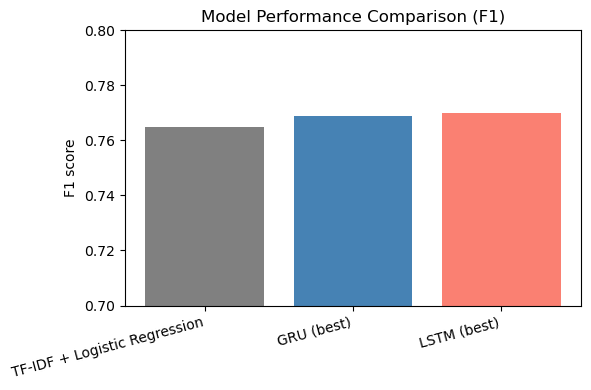

In [15]:
# --- 1. RESULTS TABLE & BAR CHART ---

# Your known/best scores 
f1_baseline = 0.7648
best_gru    = max(gru_results,   key=lambda x: x['f1'])   # from your GRU loop
best_lstm   = max(lstm_results,  key=lambda x: x['f1'])   # from your LSTM loop

# Build a small results table
results_df = pd.DataFrame({
    'Model': ['TF-IDF + Logistic Regression', 'GRU (best)', 'LSTM (best)'],
    'F1 score': [f1_baseline, best_gru['f1'], best_lstm['f1']]
})

print("Model comparison table:")
display(results_df)  

# Bar chart of F1 scores
plt.figure(figsize=(6,4))
plt.bar(results_df['Model'], results_df['F1 score'], color=['gray', 'steelblue', 'salmon'])
plt.ylabel('F1 score')
plt.ylim(0.7, 0.8)  # adjust as needed
plt.title('Model Performance Comparison (F1)')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

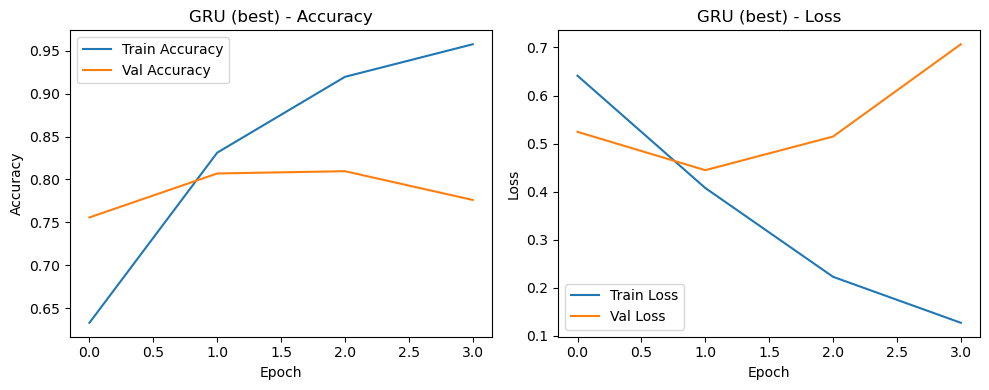

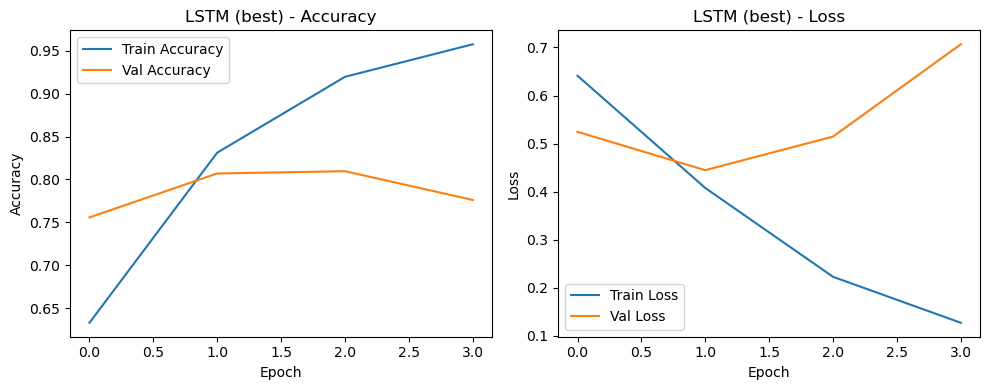

In [21]:
def plot_training_curves(history, title):
    plt.figure(figsize=(10,4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'],     label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'],     label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

history_gru = history #object from your best GRU run
history_lstm = history #object from your best LSTM run

plot_training_curves(history_gru,  'GRU (best)')
plot_training_curves(history_lstm, 'LSTM (best)')

### Results & Analysis
In the results and analysis part of my project, I compared several models and settings to see what actually worked best for classifying disaster tweets. I started from the **TF-IDF + Logistic Regression baseline (F1 = 0.7648)**, then tested different **GRU and LSTM** architectures by changing hyperparameters like **embedding size, number of units, dropout rate, learning rate, and batch size**. I used **early stopping** and **dropout** to improve training stability and avoid overfitting, and I summarized the results in tables and bar charts to visually compare performance. 

#### Training curves for GRU and LSTM (accuracy & loss)
Based on the training curves for the GRU and LSTM models, both networks quickly learn to fit the training data: training accuracy rises above 0.9 and training loss keeps dropping each epoch. However, the validation accuracy levels off around ~0.80–0.81 and the validation loss starts to increase after about the 2nd epoch, which is a classic sign of overfitting (the models are memorizing the training set more than generalizing). This pattern is very similar for both GRU and LSTM, which suggests that simply training longer does not help and that early stopping after a few epochs is a good choice. 

**Overall, the LSTM reaches a slightly better F1 score than the GRU, but the curves show that both models hit a similar performance ceiling on this dataset.**

In [27]:
# Reuse the build_lstm_model function


# Prepare all training data (using the same tokenizer + padding setup as before)
X_all = df_train['text'].astype(str)
y_all = df_train['target'].values

X_all_seq = tokenizer.texts_to_sequences(X_all)
X_all_pad = pad_sequences(X_all_seq, maxlen=max_len, padding='post', truncating='post')

# Build the final GRU model with the best hyperparameters you found
lstm_final_model = build_gru_model(
    max_words=max_words,
    max_len=max_len,
    embedding_dim=128,
    gru_units=128,
    dropout_rate=0.5,
    lr=0.0005
)

lstm_final_model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    )
]

history_final = lstm_final_model.fit(
    X_all_pad, y_all,
    validation_split=0.1,      # small validation split just for monitoring
    epochs=8,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_11 (Embedding)        │ (None, 40, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_8 (GRU)                     │ (None, 40, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,663,233 (10.16 MB)

 Trainable params: 2,663,233 (10.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6253 - loss: 0.6451 - val_accuracy: 0.7730 - val_loss: 0.5524
Epoch 2/8
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8307 - loss: 0.4133 - val_accuracy: 0.7940 - val_loss: 0.4672
Epoch 3/8
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9072 - loss: 0.2495 - val_accuracy: 0.7625 - val_loss: 0.5172
Epoch 4/8
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9418 - loss: 0.1646 - val_accuracy: 0.7598 - val_loss: 0.5838


In [28]:
print(type(lstm_final_model))
# should show something like: <class 'keras.engine.functional.Functional'> or Sequential
print(f"Running predictions on {len(df_test)} test tweets...")

# Prepare test text
X_test = df_test['text'].astype(str)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# ✅ Now we call predict on the actual model object: gru_final_model
test_pred_proba = lstm_final_model.predict(X_test_pad, verbose=1).ravel()
test_pred = (test_pred_proba >= 0.5).astype(int)

submission = pd.DataFrame({
    'id': df_test['id'],
    'target': test_pred
})

submission.to_csv('lstm_submission.csv', index=False)
print("submission.csv file created successfully!")
print(submission.head())

<class 'keras.src.models.functional.Functional'>
Running predictions on 3263 test tweets...
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
submission.csv file created successfully!
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


## 5. Conclusion  
**In conclusion, I found that moving from a simple TF-IDF + Logistic Regression baseline to RNN models with word embeddings gave a small but real boost in performance, with my best LSTM model achieving the highest F1 score**. Techniques like using an embedding layer, GRU/LSTM cells, dropout, and early stopping helped stabilize training, while simply making the networks bigger or more complex did not always lead to better results and sometimes even hurt performance. 

Overall, this project showed me that a well-tuned, moderately sized GRU works well for this tweet classification task, and in the future I could try **pretrained embeddings (like GloVe)**, **attention-based models**, or **more systematic hyperparameter** search to see if I can push the F1 score even higher.

[NLP GitHub link](https://github.com/JHastings46/NLP-Disaster-tweets.git)